# Scalable GP Regression (CUDA) in 1D (w/ KISS-GP)

This example shows how to use a `GridInterpolationKernel` module on an `ExactGP` model. This regression module is designed for when the inputs of the function you're modeling are one-dimensional.

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

Function to be modeled is  y=sin(4*pi*x)

GridInterpolationKernel exploits the regular grid structure of linspace for Toeplitz covariances

Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

# Make plots inline
%matplotlib inline

In [ ]:
# Train points ever 1/999 in [0,1]
train_x = Variable(torch.linspace(0, 1, 1000))
# Function to model is sin(4*pi*x)
# Gaussian noise from N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
# We use exact GP inference for regression
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        # Put a grid interpolation kernel over the RBF kernel
        self.base_covar_module = RBFKernel()
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=256,
                                                            grid_bounds=[(0, 1)])
        # Register kernel lengthscale as parameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# The likelihood output is a Gaussian with predictive mean and variance
likelihood = GaussianLikelihood().cuda()
# Initialize our model
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 20
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1,
                                           training_iterations,
                                           loss.data[0]))
        optimizer.step()
        
# See dkl_mnist.ipynb for explanation of this flag
with gpytorch.settings.use_toeplitz(False):
    %time train()

Iter 1/20 - Loss: 1.149
Iter 2/20 - Loss: 1.090
Iter 3/20 - Loss: 1.037
Iter 4/20 - Loss: 0.993
Iter 5/20 - Loss: 0.958
Iter 6/20 - Loss: 0.934
Iter 7/20 - Loss: 0.922
Iter 8/20 - Loss: 0.908
Iter 9/20 - Loss: 0.888
Iter 10/20 - Loss: 0.853
Iter 11/20 - Loss: 0.806
Iter 12/20 - Loss: 0.731
Iter 13/20 - Loss: 0.650
Iter 14/20 - Loss: 0.536
Iter 15/20 - Loss: 0.413
Iter 16/20 - Loss: 0.288
Iter 17/20 - Loss: 0.174
Iter 18/20 - Loss: 0.070
Iter 19/20 - Loss: -0.013
Iter 20/20 - Loss: -0.082
CPU times: user 1.04 s, sys: 208 ms, total: 1.25 s
Wall time: 1.25 s


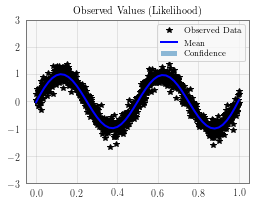

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points every 0.02 from 0 to 1 inclusive
test_x = Variable(torch.linspace(0, 1, 51)).cuda()
# Make predictions   ## Why is this set up using with?
with gpytorch.fast_pred_var(), gpytorch.settings.use_toeplitz(False):
    observed_pred = likelihood(model(test_x))

# Plotting function
def ax_plot(ax, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot train data as black stars
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    # Plot test data as blue line
    ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
    # Shade in between upper and lower bounds
    ax.fill_between(test_x.data.cpu().numpy(),
                    lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

#Plot
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')